# Baselines

In [1]:
import import_ipynb
from Auxillary_functions import *
import ECoG

importing Jupyter notebook from Auxillary_functions.ipynb


### Данные 

Будем рассматривать в качестве выборок несоклько вариантов разбиения данных.
Первый случай: данные об одной обезьяне, снятые в разные дни. Ведь в идеале хочется достичь результата, при котором модель, построенная один раз, работала ,бы для последующих экспериментов.
Второй случай: стандартное разбиение одной выборки на train/test. 

Рассматриваем subdural ECoG for monkey K from 27.05.2009

In [2]:
centers = [(4,1), (6, 1), (8,1),\
           (3, 2), (5, 2), (7,2),\
           (2, 3), (4, 3), (6, 3), (8,3),\
           (1, 4), (3, 4), (5, 4), (7, 4),\
           (2, 5), (4, 5), (6, 5), \
           (1, 6), (3, 6), (5, 6), (7, 6),\
           (2, 7), (4, 7), (6, 7), (8, 7),\
           (1, 8), (3, 8), (5, 8), (7, 8),\
           (2, 9), (4, 9), (6, 9), (8, 9),\
           (1, 10), (3, 10), (5, 10), (7, 10),\
           (2, 11), (4, 11), (6, 11), (8, 11),\
           (1, 12), (3, 12), (5, 12), (7, 12),\
           (2, 13), (4, 13), (6, 13), (8, 13),\
           (1, 14), (3, 14), (5, 14), (7, 14),\
           (2, 15), (4, 15), (6, 15), (8, 15),\
           (1, 16), (3, 16), (5, 16), (7, 16),\
           (2, 17), (4, 17), (6, 17)]

### Raw ECoG 

In [3]:
x,y = ECoG.read_ECoG_from_csv("ECoG.csv","Motion.csv")
data = ECoG.ECoG(x,y,downsample = True)

In [13]:
signal_data = np.array(x)
motion_data = np.array(y)

In [14]:
#simple sync
time, signal_idx, motion_idx = np.intersect1d(signal_data[:,0], motion_data[:,0],assume_unique=True, return_indices=True)
ecog_signal = signal_data[signal_idx]
motion = motion_data[motion_idx]

In [15]:
motion1 = []
start_pos = motion_data[0, 1:]
for i in range(len(motion_data)):
    j = motion_data[i, 1:]-start_pos
    start_pos = motion_data[i, 1:]
    motion1.append(j)
motion1 = np.array(motion1)
motion = motion1

In [16]:
from sklearn.linear_model import Lasso
lr = LinearRegression()

In [17]:
X_train, X_test, y_train, y_test, ttr, ttt = train_test_split(ecog_signal[:, 1:], motion[:, 1:], time, shuffle = False)

In [18]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
y_pred = lr.predict(X_test)

In [20]:
radj = 1-(1-r2_score(y_test,y_pred))*(len(X_test)-1)/(len(X_test)-len(X_test[0]))
print(' mae: ', mean_absolute_error(y_test, y_pred),'\n mse: ',mean_squared_error(y_test, y_pred),'\n r2-score: ',\
      radj)

 mae:  0.22411337949372168 
 mse:  0.4083014542403629 
 r2-score:  0.014962482881809791


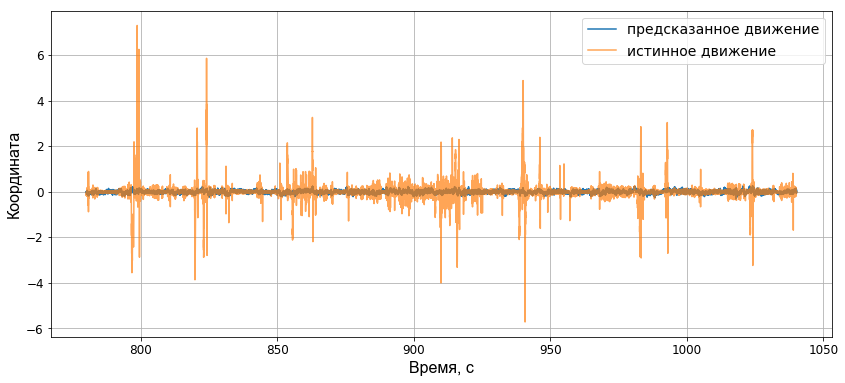

In [23]:
plt.figure(figsize = (14, 6))

plt.xticks( fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.grid(True)
plt.plot(ttt, y_pred[:,0],label = 'предсказанное движение')
plt.plot(ttt, y_test[:,0], alpha = 0.7, label = 'истинное движение' )

plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.legend(prop={'size': 14})
plt.show()

In [20]:
y_pred = lr.predict(X_train)
print(' mae: ', mean_absolute_error(y_train, y_pred),'\n mse: ',mean_squared_error(y_train, y_pred),'\n r2-score: ',\
      r2_score(y_train,y_pred))

 mae:  25.594686773737976 
 mse:  1628.7276630262302 
 r2-score:  0.055692414825227875


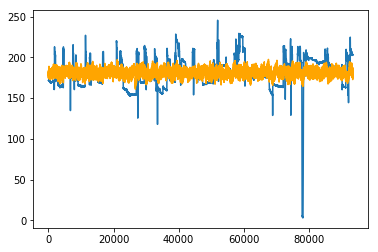

In [27]:
plt.plot(y_train[:,0])
plt.plot(y_pred[:,0], color = 'orange')

### Preprocessed ECoG 

In [28]:
filtered = data.bandpass_filter(lowcut=0.2,highcut=60,fs = 100,inplace=True) 

In [30]:
%%time
freq = np.array([i for i in range(10,150,15)]) 
scalo, motion,time = data.scalo(1,freq,start = 0,end = 3000) # preprocess first 3000(30 sec) objects of data

C:\Users\User\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\User\Anaconda3\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


Wall time: 11min 27s


In [31]:
%%time
X = scalo.reshape((scalo.shape[0],scalo.shape[1]*scalo.shape[2]*scalo.shape[3]))

Wall time: 0 ns


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, motion[:, 1:], test_size = 0.3, shuffle = False)

##### n_compomemts = 100

In [46]:
pls_motrenko_model = PLSRegression(n_components = 100)
pls_motrenko_model.fit(X_train,y_train)
y_pred = pls_motrenko_model.predict(X_test)

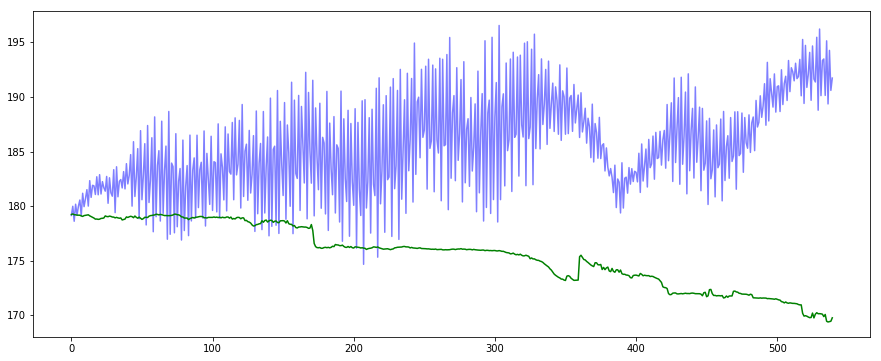

In [47]:
plt.figure(figsize = (15,6))
plt.plot(y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(y_test[:,0], color = 'green')

In [48]:
r2_score(y_test[:,0],y_pred[:, 0])

-16.662061463140862

In [49]:
y_pred = pls_motrenko_model.predict(X_train)

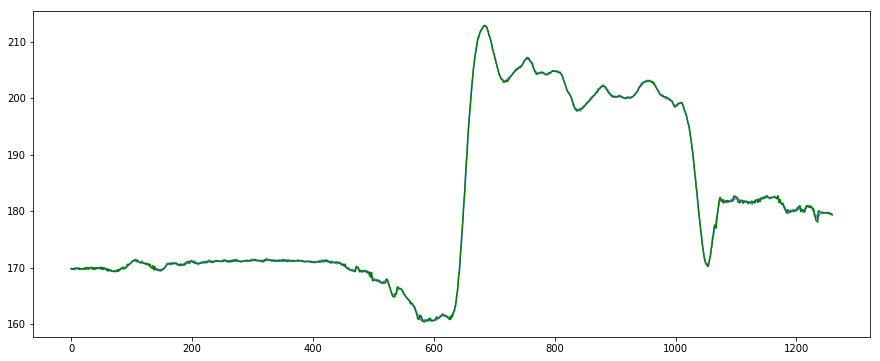

In [50]:
plt.figure(figsize = (15,6))
plt.plot(y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(y_train[:,0], color = 'green')

In [51]:
r2_score(y_train[:,0],y_pred[:, 0])

0.9998303664874003

##### n_compomemts = 50

In [33]:
pls_motrenko_model = PLSRegression(n_components = 50)
pls_motrenko_model.fit(X_train,y_train)
y_pred = pls_motrenko_model.predict(X_test)

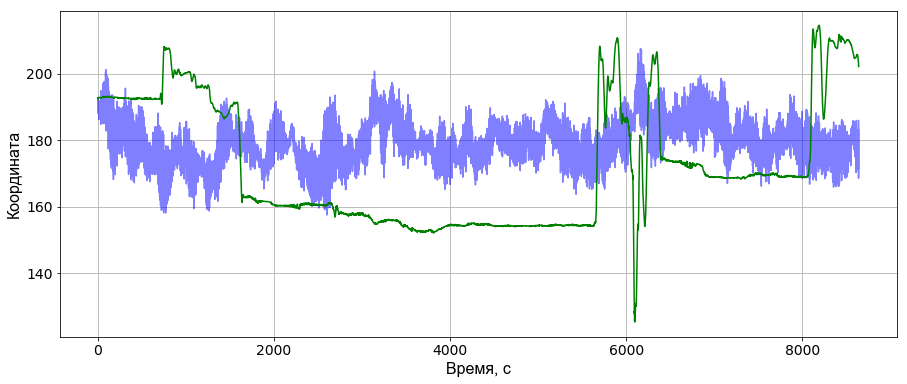

In [73]:
plt.figure(figsize = (15,6))
plt.plot(y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(y_test[:,0], color = 'green')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.grid(True)
plt.show()


In [37]:
r2_score(y_test[:,0],y_pred[:, 0])

-17.755335952576203

In [38]:
y_pred = pls_motrenko_model.predict(X_train)

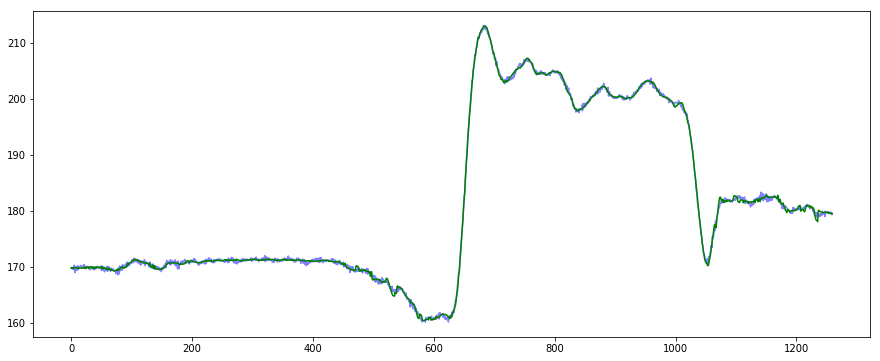

In [40]:
plt.figure(figsize = (15,6))
plt.plot(y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(y_train[:,0], color = 'green')

#### n_components = 10

In [53]:
pls_motrenko_model = PLSRegression(n_components = 10)
pls_motrenko_model.fit(X_train,y_train)
y_pred = pls_motrenko_model.predict(X_test)

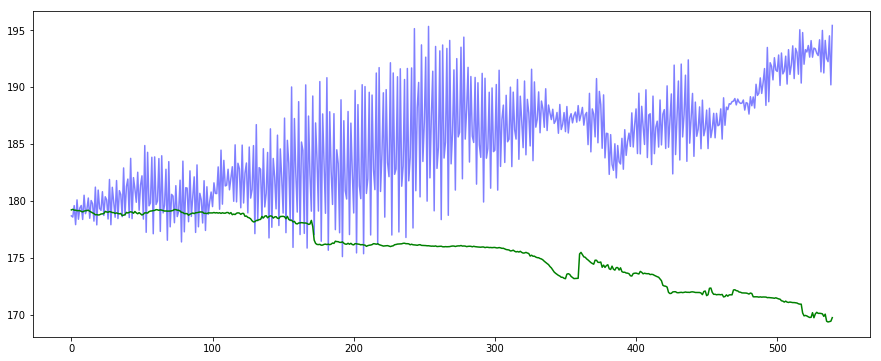

In [54]:
plt.figure(figsize = (15,6))
plt.plot(y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(y_test[:,0], color = 'green')

In [55]:
r2_score(y_test[:,0],y_pred[:, 0])

-16.8057532765693

In [56]:
y_pred = pls_motrenko_model.predict(X_train)

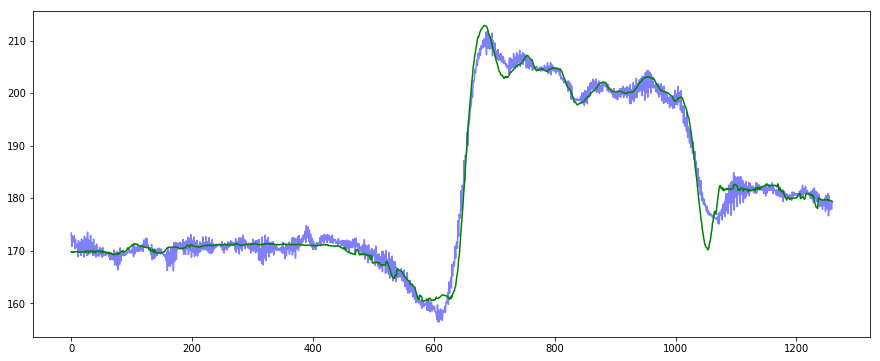

In [57]:
plt.figure(figsize = (15,6))
plt.plot(y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(y_train[:,0], color = 'green')

#### Bigger sample


In [59]:
%%time

filtered = data.bandpass_filter(lowcut=0.2,highcut=60,fs = 100,inplace=True) 


freq = np.array([i for i in range(10,150,15)]) 
scalo, motion,time = data.scalo(1,freq,start = 0,end = 30000) # preprocess first 30000(300 sec) objects of data


X = scalo.reshape((scalo.shape[0],scalo.shape[1]*scalo.shape[2]*scalo.shape[3]))

C:\Users\User\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
C:\Users\User\Anaconda3\lib\site-packages\scipy\signal\wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


Wall time: 2h 58min 58s


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, motion[:, 1:], test_size = 0.3, shuffle = False)

##### n_compomemts = 50

In [65]:
pls_motrenko_model = PLSRegression(n_components = 50)
pls_motrenko_model.fit(X_train,y_train)


In [80]:
y_pred = pls_motrenko_model.predict(X_test)

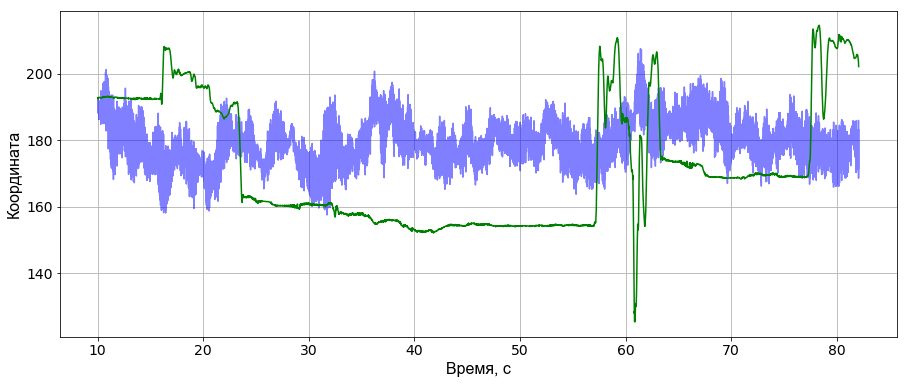

In [81]:
plt.figure(figsize = (15,6))
plt.plot(time[:len(y_test)],y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(time[:len(y_test)],y_test[:,0], color = 'green')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.grid(True)
plt.show()

In [72]:
print(' r2: ', r2_score(y_test[:,0],y_pred[:, 0]), '\n mae:',
mean_absolute_error(y_test[:,0],y_pred[:, 0]), '\n mse:',
mean_squared_error(y_test[:,0],y_pred[:, 0]))

 r2:  -0.3700073745869823 
 mae: 19.520344857938277 
 mse: 472.42361310107367


In [76]:
y_pred = pls_motrenko_model.predict(X_train)

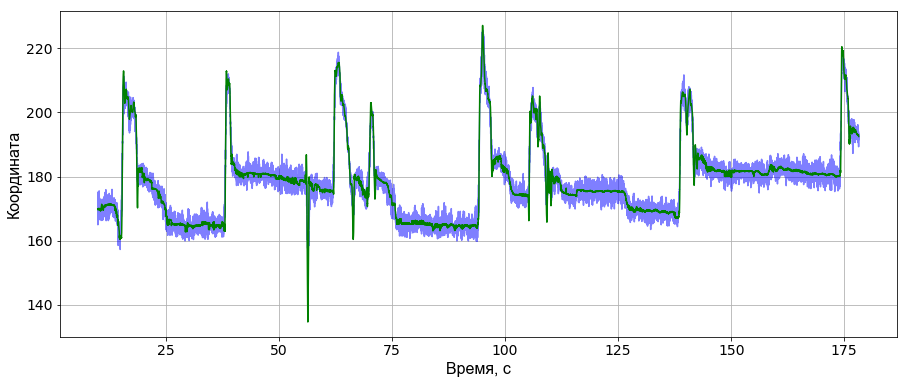

In [79]:
plt.figure(figsize = (15,6))
plt.plot(time[:len(y_train)],y_pred[:,0], color = 'blue', alpha = 0.5)
plt.plot(time[:len(y_train)],y_train[:,0], color = 'green')
plt.xticks( fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('Время, с', **axis_font)
plt.ylabel('Координата', **axis_font)
plt.grid(True)
plt.show()


In [70]:
print(' r2: ', r2_score(y_train[:,0],y_pred[:, 0]), '\n mae:',
mean_absolute_error(y_train[:,0],y_pred[:, 0]), '\n mse:',
mean_squared_error(y_train[:,0],y_pred[:, 0]))

 r2:  0.9597070557804057 
 mae: 1.6870327062097323 
 mse: 5.37524723726338
